1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step


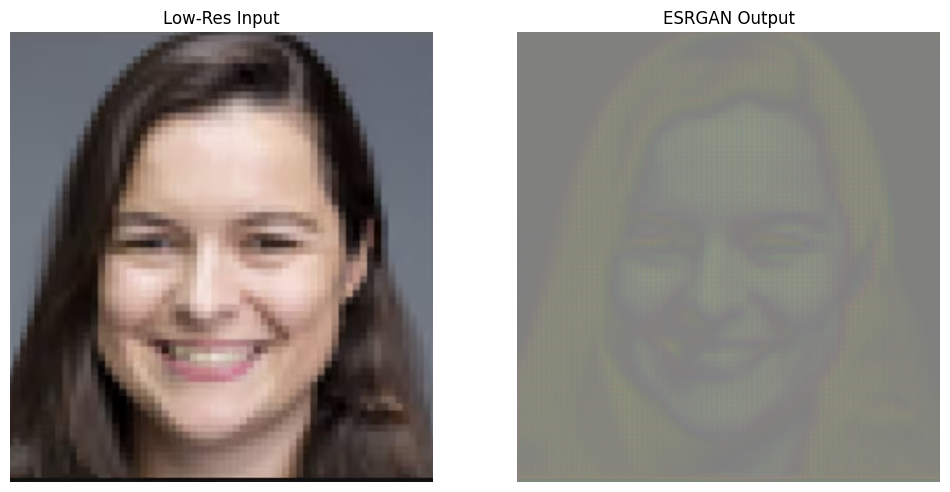

True

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- RRDB Block ---
def dense_block(x, filters, growth=32):
    concat_feat = [x]
    for i in range(5):
        out = layers.Conv2D(growth, 3, padding='same', activation='relu')(x)
        concat_feat.append(out)
        x = layers.Concatenate()(concat_feat)
    out = layers.Conv2D(filters, 3, padding='same')(x)
    return layers.Add()([out, concat_feat[0]])

def rrdb_block(x, filters):
    out = dense_block(x, filters)
    out = dense_block(out, filters)
    out = dense_block(out, filters)
    return layers.Add()([x, out * 0.2])



def build_esrgan_generator(num_rrdb=5, filters=64, input_shape=(None, None, 3)):
    inputs = layers.Input(shape=input_shape)
    fea = layers.Conv2D(filters, 3, padding='same')(inputs)

    x = fea
    for _ in range(num_rrdb):
        x = rrdb_block(x, filters)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.Add()([fea, x])

    # Upsample 2x twice → total 4x
    for _ in range(2):
        x = layers.Conv2D(filters * 4, 3, padding='same')(x)
        x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

    outputs = layers.Conv2D(3, 3, padding='same', activation='tanh')(x)
    return models.Model(inputs, outputs)

# Build generator
generator = build_esrgan_generator()



# Load low-resolution image
img = cv2.imread("/content/test_lr1.png")
if img is None:
    raise FileNotFoundError("Image not found!")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Normalize to [-1, 1] as ESRGAN expects
input_img = img.astype(np.float32)
input_img = input_img / 127.5 - 1.0
input_img = np.expand_dims(input_img, axis=0)  # add batch dimension


sr_img = generator.predict(input_img)[0]
sr_img = (sr_img + 1.0) * 127.5  # denormalize back to [0, 255]
sr_img = np.clip(sr_img, 0, 255).astype(np.uint8)



plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Low-Res Input")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sr_img)
plt.title("ESRGAN Output")
plt.axis("off")

plt.show()

# Optionally save
cv2.imwrite("output_esrgan5.png", cv2.cvtColor(sr_img, cv2.COLOR_RGB2BGR))

GAN - tanh activation function